In [1]:
# Libraries and figure settings
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import seaborn as sns
import requests
import time
import matplotlib
plt.style.use('fivethirtyeight')

### TODO: 
- Simplificar nombres CCAA
- Calcular total nacional
- Calcular valores per capita
- Mostrar lineas verticales en las visualizaciones
- Arreglar figura superior

## COVID-19 data analysis

Voy a utilizar el dataset del centro nacional de epidemiologia (se actualiza todos los dias)

In [2]:
req = requests.get("https://covid19.isciii.es/resources/serie_historica_acumulados.csv")
csv = req.content.decode('ISO-8859-1')

filename = 'serie_historica_acumulados.csv'
with open(filename, 'w') as f:
    f.write(csv)

### Obtengo el censo de CCAA de España

Una vez más, los datos los he sacado de https://datos.gob.es/

```
https://datos.gob.es/es/catalogo/ea0010587-poblacion-por-sexo-edad-grupos-quinquenales-y-pais-de-nacimiento-comunidades-autonomas-y-provincias-censos-de-poblacion-y-viviendas-identificador-api-t20-e244-avance-p01-l0-04007-px
```


In [9]:
censo=pd.read_csv('censo_espana_2011.csv', skiprows=5, nrows=63, sep=';', header=[0,1], index_col=0) # a partir de esta fila segregan los datos por pais de origen

censo_total = censo['Ambos sexos'].reset_index()
censo_total['TOTAL'] = censo_total['TOTAL'].apply(lambda x: x.strip()) # elimino espacios innecesarios
censo_total['Total'] = censo_total['Total'].apply(lambda x: int(x.replace('.', '')))

es_ccaa = censo_total.TOTAL == censo_total.TOTAL.apply(lambda x: x.upper()) # las CCAA vienen en todo mayusculas
ceuta_melilla = censo_total.TOTAL.isin(['Ceuta', 'Melilla'])
censo_ccaa = censo_total[es_ccaa | ceuta_melilla].reset_index(drop=True)

censo_ccaa = censo_ccaa.rename(columns={'TOTAL':'CCAA', 'Total':'Poblacion'})

censo_ccaa['CCAA'] = censo_ccaa['CCAA'].apply(lambda x: x.lower().title()) # title es como capitalize() pero para todas las palabras de la cadena

# censo_ccaa[censo_ccaa.CCAA != 'Total Nacional'].Poblacion.sum()  # 46815919 check

ccaas = ['Nacional', 'Andalucia', 'Aragon', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla y Leon',
           'Castilla la Mancha', 'Catalunya', 'C. Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Murcia', 'Navarra', 
           'Euskadi', 'La Rioja', 'Ceuta', 'Melilla']

censo_ccaa['CCAA'] = ccaas
censo_ccaa

,CCAA,Poblacion
0,Nacional,46815916
1,Andalucia,8371270
2,Aragon,1344509
3,Asturias,1075183
4,Baleares,1100503
5,Canarias,2082655
6,Cantabria,592542
7,Castilla y Leon,2540188
8,Castilla la Mancha,2106331
9,Catalunya,7519843


### Algunos datos auxiliares

In [52]:
nombres_ccaa = {'AN':'Andalucia', 'AR':'Aragon', 'AS':'Asturias', 'CB':'Cantabria', 'CE':'Ceuta',
                'CL':'Castilla y Leon', 'CM':'Castilla la Mancha', 'CN':'Canarias', 'CT':'Catalunya', 'EX':'Extremadura',
                'GA':'Galicia','IB':'Baleares', 'MC':'Murcia', 'MD':'Madrid', 'ME':'Melilla',
                'NC':'Navarra','PV':'Euskadi', 'RI':'La Rioja', 'VC':'C. Valenciana'
               }

# fechas cuarentena (fuente: https://es.wikipedia.org/wiki/Cuarentena_de_Espa%C3%B1a_de_2020 )
inicio_cuarentena_madrid = np.datetime64('2020-03-11') # cierre colegios?
inicio_cuarentena = np.datetime64('2020-03-15')
fase_dos_cuarentena = np.datetime64('2020-03-30')

### Parseo los datos de la epidemia

In [96]:
df = pd.read_csv('serie_historica_acumulados.csv', parse_dates=[1], infer_datetime_format=True )
df.tail(3)  #examinamos cuantas filas del final no tenemos que leer

,CCAA Codigo ISO,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados
835,RI,2020-04-03,2405.0,805.0,64.0,128.0,843.0
836,NOTA: El objetivo de los datos que se publican...,NaT,NaN,NaN,NaN,NaN,NaN
837,Los datos de estas comunidades son datos de pr...,NaT,NaN,NaN,NaN,NaN,NaN


In [97]:
df = df[:-2]  # elimino comentario de la ultima fila
df = df.rename(columns={'CCAA Codigo ISO':'CCAA', 'Casos ':'Casos'})
df = df.fillna(0)
df['CCAA'] = df['CCAA'].apply(lambda x: nombres_ccaa[x])

# Elimino los registros sin casos
df = df[df['Casos'] > 0]

# Calculo los nuevos casos por CCAA y el total nacional
df = df.sort_values(by=['CCAA','Fecha']).reset_index(drop=True)

total_nacional = df.groupby('Fecha').sum().reset_index()
total_nacional['CCAA'] = ['Nacional']*len(total_nacional)

df = pd.concat([total_nacional, df], ignore_index=True)

df['Activos'] = df['Casos'] - df['Recuperados'] - df['Fallecidos']

for col in ['Casos', 'Activos', 'Fallecidos', 'Recuperados', 'Hospitalizados', 'UCI']: 
    df['nuevos' + col] = df.groupby('CCAA')[col].diff().fillna(0)
    
# Dias desde el inicio de la epidemia por CCAA
df['Dias'] = df.groupby('CCAA')['Fecha'].transform(lambda x: x - x.iloc[0]).dt.days  # magia negra

# Checkeamos si los casos activos son no-decrecientes
#for ccaa in df.CCAA.unique():
#    dfaux = df[df.CCAA==ccaa]
#    activos_creciente = [ a <= b for a, b in zip(dfaux.Activos, dfaux.Activos[1:])]
#    print('{}\t{}\t'.format(ccaa, all(activos_creciente)))

print(df.dtypes)
df.head()

CCAA                            object
Casos                          float64
Fallecidos                     float64
Fecha                   datetime64[ns]
Hospitalizados                 float64
Recuperados                    float64
UCI                            float64
Activos                        float64
nuevosCasos                    float64
nuevosActivos                  float64
nuevosFallecidos               float64
nuevosRecuperados              float64
nuevosHospitalizados           float64
nuevosUCI                      float64
Dias                             int64
dtype: object


,CCAA,Casos,Fallecidos,Fecha,Hospitalizados,Recuperados,UCI,Activos,nuevosCasos,nuevosActivos,nuevosFallecidos,nuevosRecuperados,nuevosHospitalizados,nuevosUCI,Dias
0,Nacional,2.0,0.0,2020-02-20,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Nacional,2.0,0.0,2020-02-21,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Nacional,2.0,0.0,2020-02-22,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Nacional,2.0,0.0,2020-02-23,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,Nacional,3.0,0.0,2020-02-24,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,4


### Suavizo todas las columnas interesantes

In [121]:
# Columnas de interes
cols = ['Casos','Activos','Recuperados', 'Fallecidos']
cols += ['nuevos' + col for col in cols] + ['Dias']

for col in cols:
    valores_suavizados = []
    for ccaa in df.CCAA.unique():
        valores_suavizados += df[df.CCAA==ccaa][col].rolling(5, win_type='triang', center=True, min_periods=1).mean().values.tolist()    
    df[col + '_suave'] = valores_suavizados        

### Calculo los casos per capita

# Visualizacion


### Pruebas media movil para Madrid

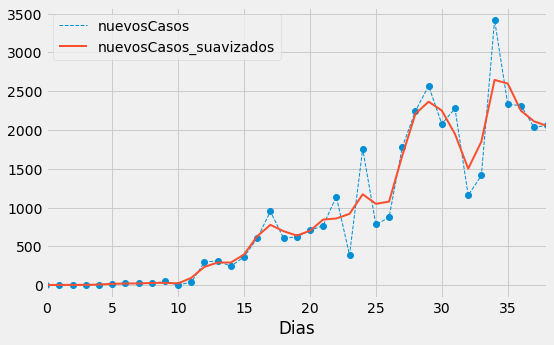

In [79]:
# Equivale a usar 0.25*valor_anterior + 0.5*valor_actual + 0.25*valor_siguiente
dfaux['nuevosCasos_suavizados'] = dfaux.nuevosCasos.rolling(3, win_type='triang', center=True, min_periods=1).mean()  # 

fig, ax = plt.subplots(figsize=(8,5))
dfaux.plot(x='Dias', y='nuevosCasos', style= 'o--', lw=1, ax=ax)
dfaux.plot(x='Dias', y='nuevosCasos_suavizados', lw=2, ax=ax)

#print(dfaux.nuevosCasos.tolist())
#print(dfaux.nuevosCasos_suavizados.tolist())
#np.array([2315, 2033, 2061]).dot(np.array([0.25, 0.5, 0.25]))    #2110,5
#np.array([2033, 2061]).dot(np.array([1/3, 2/3]))                 #2051.6666  #solo usa 2 valores en los bordes

## Total casos vs Nuevos casos

Una exponencial pura se vería como una recta. Caidas respecto a la recta en los últimos valores representan un alejamiento del crecimiento exponencial, y por tanto un aplanamiento de la curva

(10, 20000)

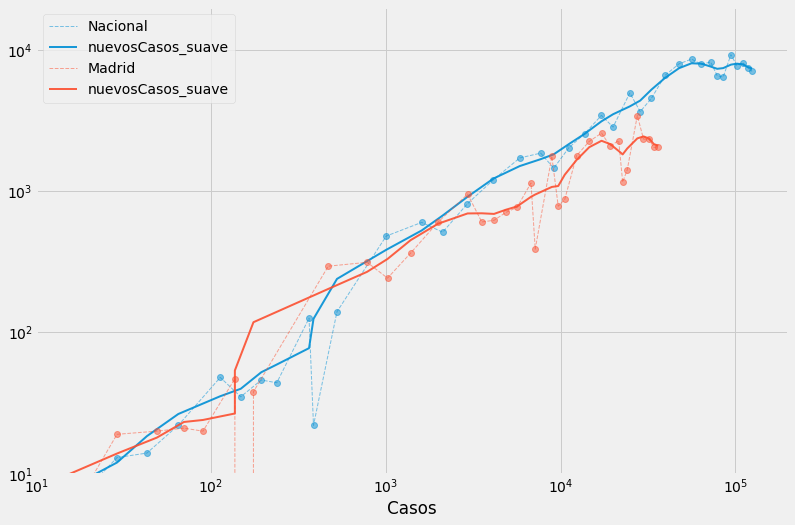

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))

selected_ccaa = ['Nacional', 'Madrid']

cmap = ['b', 'r']

for i, ccaa in enumerate(selected_ccaa):
    line = df[df.CCAA == ccaa].plot(x='Casos', y='nuevosCasos', label=ccaa, style= 'o--', lw=1, alpha=0.5, loglog=True, ax=ax)
    ultima_linea = line.get_lines()[-1]
    ultima_linea.get_color
    df[df.CCAA == ccaa].plot(x='Casos', y='nuevosCasos_suave', loglog=True, ax=ax,
                             style='-', color=ultima_linea.get_color(), lw=2, alpha=0.9,)

ax.set_xlim([10, 2*10**5])    
ax.set_ylim([10, 2*10**4])

### Algunas visualizaciones para Madrid

Parece que faltan datos de Hospitalizados, UCI y Fallecidos los primeros días

In [27]:
madrid = df[df.CCAA == 'Madrid, Comunidad De']
madrid.head()

,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,CCAA,nuevosCasos,nuevosFallecidos,nuevosRecuperados,nuevosHospitalizados,nuevosUCI,Dias
452,2020-02-25,2.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",0.0,0.0,0.0,0.0,0.0,0
453,2020-02-26,4.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",2.0,0.0,0.0,0.0,0.0,1
454,2020-02-27,5.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",1.0,0.0,0.0,0.0,0.0,2
455,2020-02-28,8.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",3.0,0.0,0.0,0.0,0.0,3
456,2020-02-29,10.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",2.0,0.0,0.0,0.0,0.0,4


/usr/lib64/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


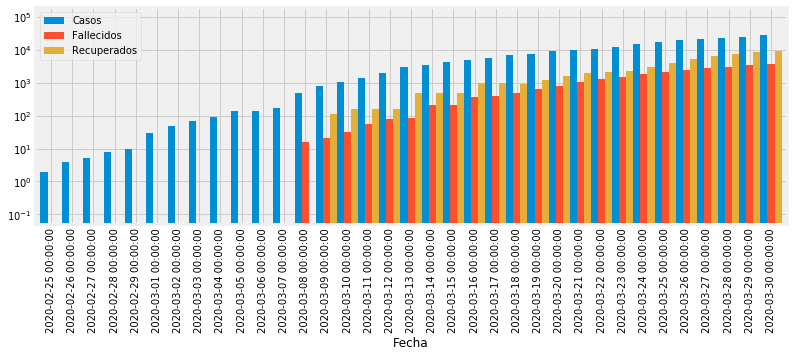

In [28]:
es_madrid = df.CCAA.apply(lambda x: x.find('Madrid') != -1) # otra manera de filtrar por CCAA

fig, ax = plt.subplots()

nuax = df[es_madrid].plot(x='Fecha', y=['Casos', 'Fallecidos', 'Recuperados'],  #'Hospitalizados','UCI', 
                   kind='bar',  width=1.0, figsize=(12,4), logy=True, ax=ax)

nuax.plot([inicio_cuarentena_madrid]*2, [0.1, 10**5], 'k')
fig.show()
#ax.axvline(x=inicio_cuarentena_madrid, ymin=0.1, ymax=10**5, color='k')
#ax.axvline(pd.to_datetime(inicio_cuarentena_madrid), color='k', linestyle='--', lw=10)


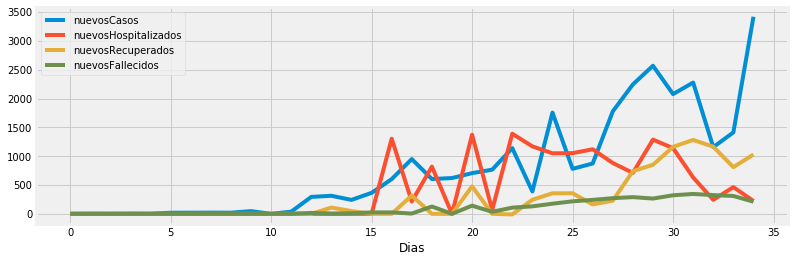

In [29]:
df[es_madrid].plot(x='Dias', y=['nuevosCasos', 'nuevosHospitalizados','nuevosRecuperados', 'nuevosFallecidos'], 
                   kind='line',   figsize=(12,4), logy=False, ) #kind ='bar', width=0.8,